Author: Lewis Li

## Introduction

In this notebook, we will demonstrate the application of Sequential Importance Sampling to generate reservoir models that match the predictions generated by Evidential Learning. There are two main motivations for this workflow. The first is to recover the reservoir model parameters that correspond to Evidential Learning, which can be used for quality checking and other physical simulations. The second pertains to the situation where the observed data resides within the tails of the prior distribution. Under these circumstances, it may be helpful to generate additional models in the vicinity of the observed data in order to refine our prediction. Moreover, such a workflow can be applied as additional data becomes available (the data assimilation problem).

<img src="../figures/SIR/FieldOverview.png",width="600",style="float: center">

We will consider the same Libyan reservoir as the Evidential Learning tutorial. Our goal is to predict the performance of a new infill to be drilled at location PNEW after 8000 days of production using the production rates from the five existing producers after different periods of time. 



## Targeted Sampling With SIR
We propose to use Sequential Importance Resampling (SIR) to obtain subsurface models from $f(\mathbf{m}|\mathbf{d}_{obs})$ (which we will refer to as thetarget distribution). Importance sampling is a well-known statistical method that uses a different proposal distribution to focus the sampling of the target distribution of interest, with the aim to make such sampling more efficient (e.g. sample more the tail than the center). It is a variance reduction method that is used in conjunction with Monte Carlo, that emphasizes sampling more in the regions considered to be more important. However, the use of a different distribution will result in a biased estimate of the underlying variable, therefore to compensate, a weight must be attached to each sample.  The weight is equivalent to the likelihood ratio between the underlying target distribution and the biased proposal distribution. We propose a simple proposal distribution for each model parameter based on Bayes’ Rule. Since the actual target distribution $f(\mathbf{m}|\mathbf{d}_{obs})$ remains unknown, we propose instead to use the posterior distribution of $\mathbf{h}$ as a summary statistic to thus perform the weighting.

<img src="../figures/SIR/Flowchart.png",width="600",style="float: center">

### Importance Sampling
Before we discuss the specific target function $f(\mathbf{m}|\mathbf{d}_{obs})$, let us first consider sampling an arbitrary \acs{RV} $\mathbf{x}$ which has values given by $v(\mathbf{x})$ and \acs{pdf} $p(\mathbf{x})$. Suppose we wish to compute the expected value of $\mathbf{x}$ using Monte Carlo. We would proceed as:
$$
E\left[ v(\mathbf{x}) \right]  =  \int v(\mathbf{x}) p(\mathbf{x}) d\mathbf{x} \approx \frac{1}{N} \sum_{i=1}^N v(\mathbf{x}_i) p(\mathbf{x}_i) \\
\mathbf{x}_i  \sim  p(\mathbf{x}) 
$$
That is we would sample $\mathbf{x}$ from $p(\mathbf{x})$ and use it to evaluate the expected value. We see that each sample generated $\mathbf{x}_i$ is equivalently weighted when computing the expected value. However, if $p(\mathbf{x})$ is difficult to sample (i.e. we are only interested in the tail region), a large number of samples of $\mathbf{x}$ would be required in order for the statistic (in this case the mean) to converge. Importance sampling introduces a new distribution termed the *proposal* distribution denoted $q(\mathbf{x})$, and rewrites the previous expression as:
$$
E\left[ v(\mathbf{x}) \right]  = \int \frac{p(\mathbf{x})}{q(\mathbf{x})} v(\mathbf{x}) q(\mathbf{x}) d\mathbf{x} \approx \frac{1}{N} \sum_{i=1}^N \frac{p(\mathbf{x_i})}{q(\mathbf{x_i})} v(\mathbf{x}_i) q(\mathbf{x}_i) \\
\mathbf{x}_i \sim q(\mathbf{x}) 
$$
The distinction is now the samples $\mathbf{x}_i$ are drawn from $q(\mathbf{x})$. Furthermore, instead of each sample being equi-probable, they have a weight associated with it:
$$
w_i = \frac{p(\mathbf{x}_i)}{q(\mathbf{x}_i)}
$$
This weight is required to correct for the bias that results from sampling from $q(\mathbf{x})$. The choice of the proposal distribution is clearly fundamental for importance sampling, as an appropriate choice can result in dramatic decrease in number of required samples, while a poor distribution can result in even slower convergence than regular Monte Carlo.

### A 1D Gaussian Example
Suppose we are trying to estimate $P(x > 4)$ where $x \sim \mathcal{N}(0,1)$. Regular Monte Carlo would require a large number of samples to estimate this probability as very few samples drawn from $f(x) = \mathcal{N}(0,1)$ would be greater than $4$. Let us try it first with 10000 samples.


In [1]:
nSamples = 10000;

% Generate samples from target distribution
x = randn(nSamples,1);

estimate_mc = sum(x>4)/nSamples


estimate_mc =

     0



With 1000 samples, chances are Monte Carlo will return a value of 0 or $10^{-5}$. Let us try importance sampling with the proposal function $q(x) = \mathcal{N}(4,2)$. 

In [2]:
% Generate samples from proposal distribution
q_x = randn(nSamples,1)*2 + 4;

% Evaluate the weight
pdf_q = normpdf(q_x,4,2);
pdf_p = normpdf(q_x,0,1);
w = pdf_p./pdf_q;

estimate_is = mean(w.*(q_x>4))

% Analyical solution
analyical_solution = 1-normcdf(4,0,1)


estimate_is =

   3.0994e-05


analyical_solution =

   3.1671e-05



If we compare the importance sampling estimate to the analytical solution, we can see that importance sampling yields a much closer estimate than Monte Carlo with the same number of samples. This illustrates that the sampling is more efficient than conventional Monto Carlo. We next explore how this concept can be applied to sub-surface modeling

## SIR For Subsurface Modeling
Before, we examine the specifics of the target and proposal distribution, let us consider the uncertanties that we have on the model. We will examine 12 non-gridded parameters pertain to the reservoir fluid characteristics (relative permeability, oil viscosity, etc), as well as the transmissibility of the four faults in the reservoir. The prior on these parameters is shown below:

Name  |  Symbol |  Prior $f(m_i)$ 
-----------------------|--------------------|--------------------
Oil Water Contact | $OWC$ |  $\mathcal{U}[1061,1076]$ 
Fault 1 Transmissibility Multiplier | $F_1$ | $\mathcal{U}[0,1]$
Fault 2 Transmissibility Multiplier | $F_2$ | $\mathcal{U}[0,1]$
Fault 3 Transmissibility Multiplier | $F_3$ | $\mathcal{U}[0,1]$
Fault 4 Transmissibility Multiplier | $F_4$ | $\mathcal{U}[0,1]$
Oil Viscosity | $\mu$ | $\mathcal{N}(4,0.5)$ 
Irreducible Oil Saturation | $S_{or}$ | $\mathcal{N}(0.2,0.05)$ 
Irreducible Water Saturation | $S_{wc}$ | $\mathcal{N}(0.2,0.05)$ 
Oil End Point Relative Perm K | $k_{ro}$ | $\mathcal{U}[0.1,0.4]$ 
Water End Point Relative Perm K | $k_{rw}$ | $\mathcal{U}[0.1,0.4]$ 
Corey Coefficient Oil | $n_{o}$ | $\mathcal{U}[2,3]$ 
Corey Coefficient Water | $n_{w}$ | $\mathcal{U}[4,6]$ 

### The Target Distribution
The target distribution that we wish to sample is:

$$f(\mathbf{m}|\mathbf{d}_{obs}) = f(m_1,m_2,..., m_{12}|\mathbf{d}_{obs})$$

This represents the set of reservoir models that generates $\mathbf{d}$ that matches $\mathbf{d}_{obs}$. This is a high dimensional distribution (in this case 12D) that cannot be directly specified nor sampled. We can imagine that very few combinations of $\left\lbrace m_1,\cdots,m_{12}\right\rbrace$ would yield a $\mathbf{d}$ that matches $\mathbf{d}_{obs}$, necessitating the application of SIR.

### The Proposal Distribution
if we consider each component of $\mathbf{m}$ independently $m_n$, we then write the target distribution as $f(m_1,m_2,..., m_N|\mathbf{d}_{obs})$. If we make the assumption of *conditional independence* between each of the model components, then a possible choice of a proposal distribution is:
$$q(m_1,m_2,..., m_N|\mathbf{d}_{obs}) = \prod_{n=1}^N f(m_n|\mathbf{d}_{obs})$$

In general, this assumption of conditional independence is not true, thus sampling from $q(\mathbf{m})$ introduces a bias. We will correct for this bias in the next section. However, estimating each of the $f(m_n|\mathbf{d}_{obs})$ distributions is a far easier task than the entire posterior. Since $m_n$ is a single parameter and thus univariate, it can be estimated using conventional statistical approaches such as Kernel Density Estimation. The procedure can be summarized as:

1. Construct prior models by sampling from $f(\mathbf{m})$ using Monte Carlo and/or geostatistical simulation.
2. Forward simulate using $g_d(\cdot)$ each of the prior models to generate prior realizations of $\mathbf{d}$.
3. Apply any necessary dimension reduction on $\mathbf{d}$ and $\mathbf{d}_{obs}$ to yield $\mathbf{d}^*$ and $\mathbf{d}^*_{obs}$.
4. Estimate $f(m_n|\mathbf{d}^*_{obs})$ for each $m_i$ using KDE


## Construction of the Prior Models
We begin by sampling our prior models by applying Monte Carlo on the prior distributions shown in the table above. We generated 500 prior models and forward simulated them to 12000 days using 3DSL. After 1000 days, we would like to make our first prediction regarding the future production of the new well. We begin by loading both the **prior** and **observed** data at 1000 days. The results were processed from the 3DSL output into the same struct described in the EvidentialLearning notebook.

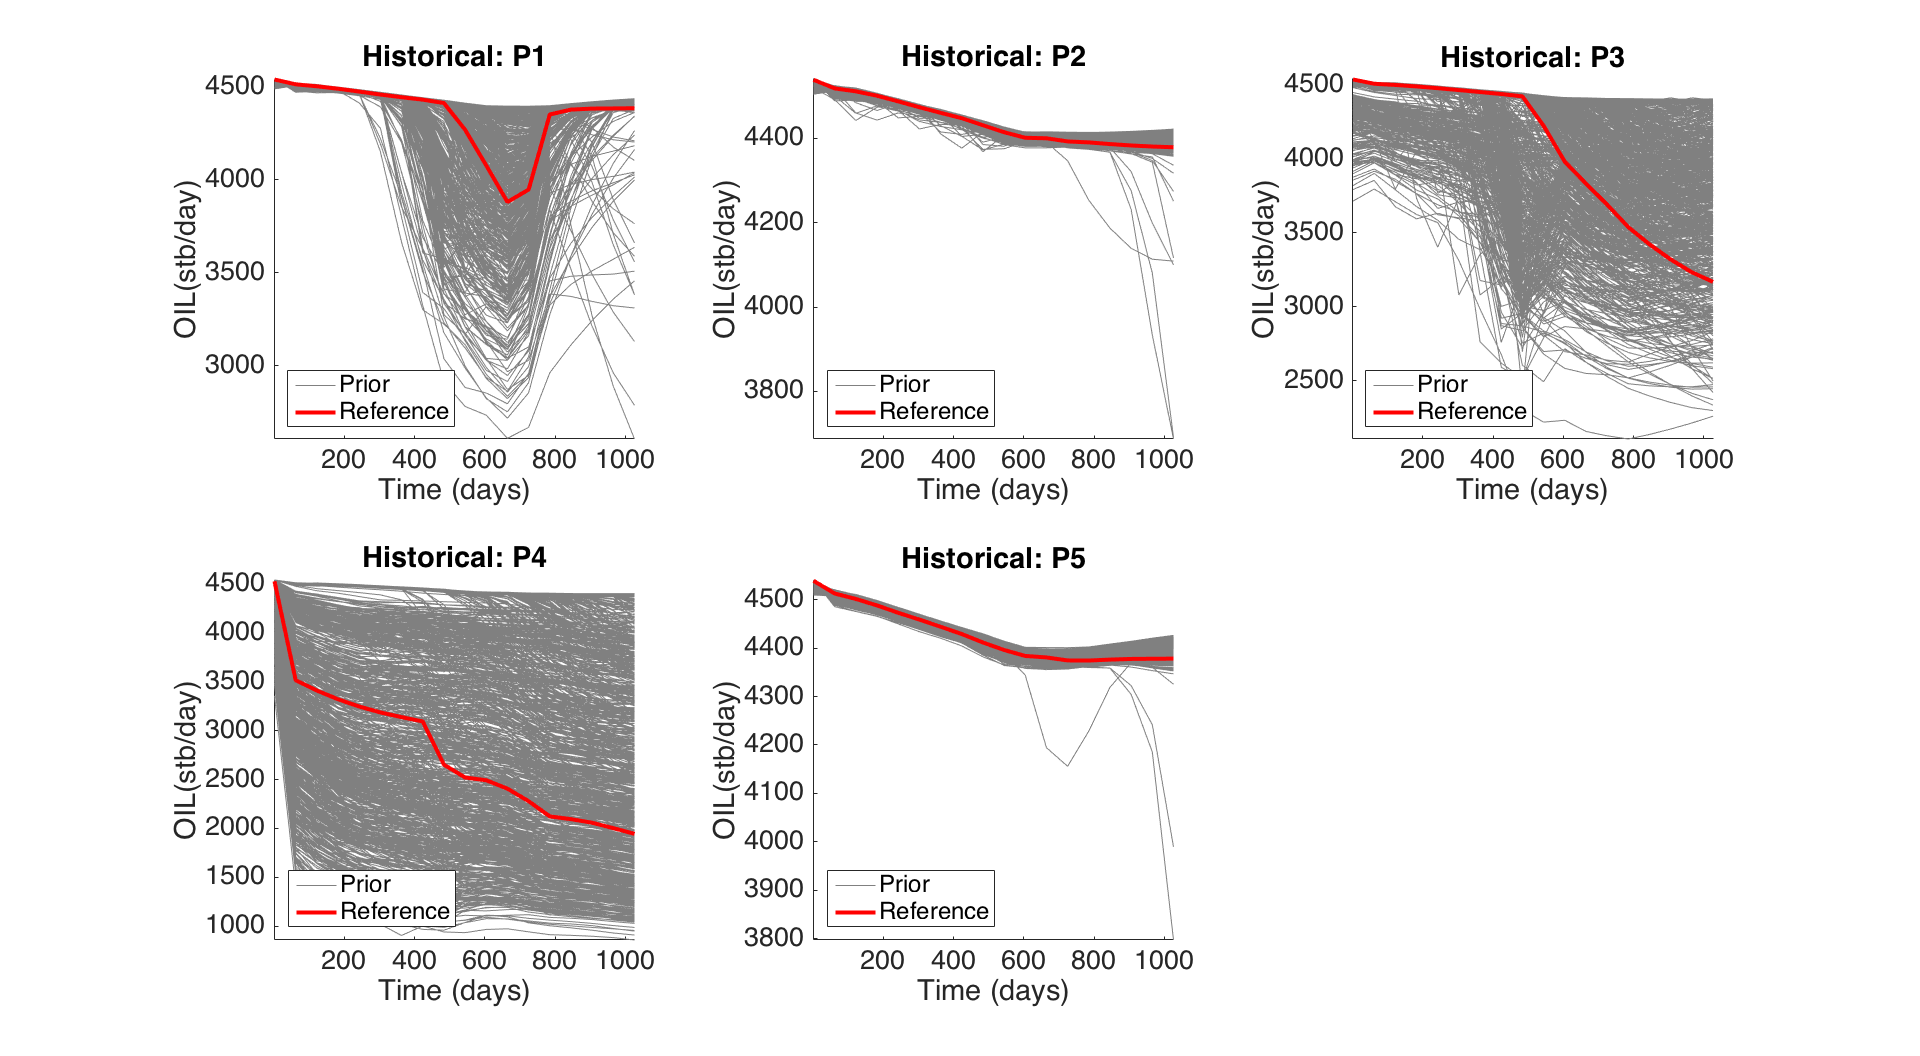

In [5]:
%plot inline -s 1920,1080
addpath('../src/evidential/');
addpath('../src/sir/');

load('../data/SIR/3dslresults/Prior.mat');
load('../data/SIR/3dslresults/Time1000/Observed.mat')

FontSize = 20;
PlotResponses(PriorData,TrueData,FontSize);

We next load the parameters that correspond to each of the prior models. 

In [7]:
load('../data/SIR/parameters/Prior/Sampled.mat');

## Estimating The Proposal Distribution
To estimate the proposal distribution, we will perform dimension reduction on the data variable, and then apply Kernel Density Estimation on each of the model parameters.

### Dimension Reduction
We apply Functional Data Analysis followed by Mixed PCA on both the data and observed data responses.